In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

给定x，我们将使用以下三阶多项式来生成训练和测试数据的标签：

y=5+1.2x-3.4*x²/（2！）+5.6*x三次方/（3！）+c where c~N(0,0.1²)

In [2]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [3]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.0253],
         [ 0.8403]]),
 tensor([[ 1.0000e+00, -2.5277e-02,  3.1946e-04, -2.6917e-06,  1.7010e-08,
          -8.5990e-11,  3.6226e-13, -1.3081e-15,  4.1332e-18, -1.1608e-20,
           2.9343e-23, -6.7427e-26,  1.4203e-28, -2.7616e-31,  4.9861e-34,
          -8.4022e-37,  1.3274e-39, -1.9730e-42,  2.8026e-45, -0.0000e+00],
         [ 1.0000e+00,  8.4025e-01,  3.5301e-01,  9.8873e-02,  2.0770e-02,
           3.4904e-03,  4.8880e-04,  5.8674e-05,  6.1626e-06,  5.7535e-07,
           4.8344e-08,  3.6928e-09,  2.5858e-10,  1.6713e-11,  1.0031e-12,
           5.6190e-14,  2.9508e-15,  1.4585e-16,  6.8084e-18,  3.0109e-19]]),
 tensor([4.9007, 5.4544]))

In [4]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [5]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 5.00328    1.1830277 -3.421422   5.6385818]]


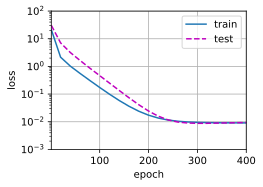

In [6]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[3.3762014 3.202347 ]]


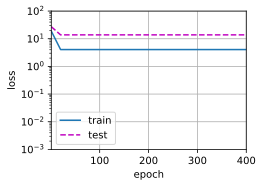

In [7]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.971334    1.2068932  -3.2445414   5.397957   -0.5625301   1.2007471
  -0.24678938 -0.0683412   0.08019084  0.09235634 -0.05247705  0.02796281
   0.10643125 -0.10417848 -0.20168611  0.01690977 -0.09550583 -0.19975552
  -0.06166832 -0.20663412]]


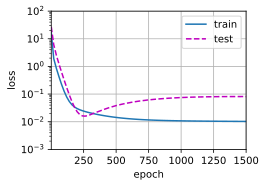

In [8]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)